Build a simple CNN Auto-Encoder to color image. 

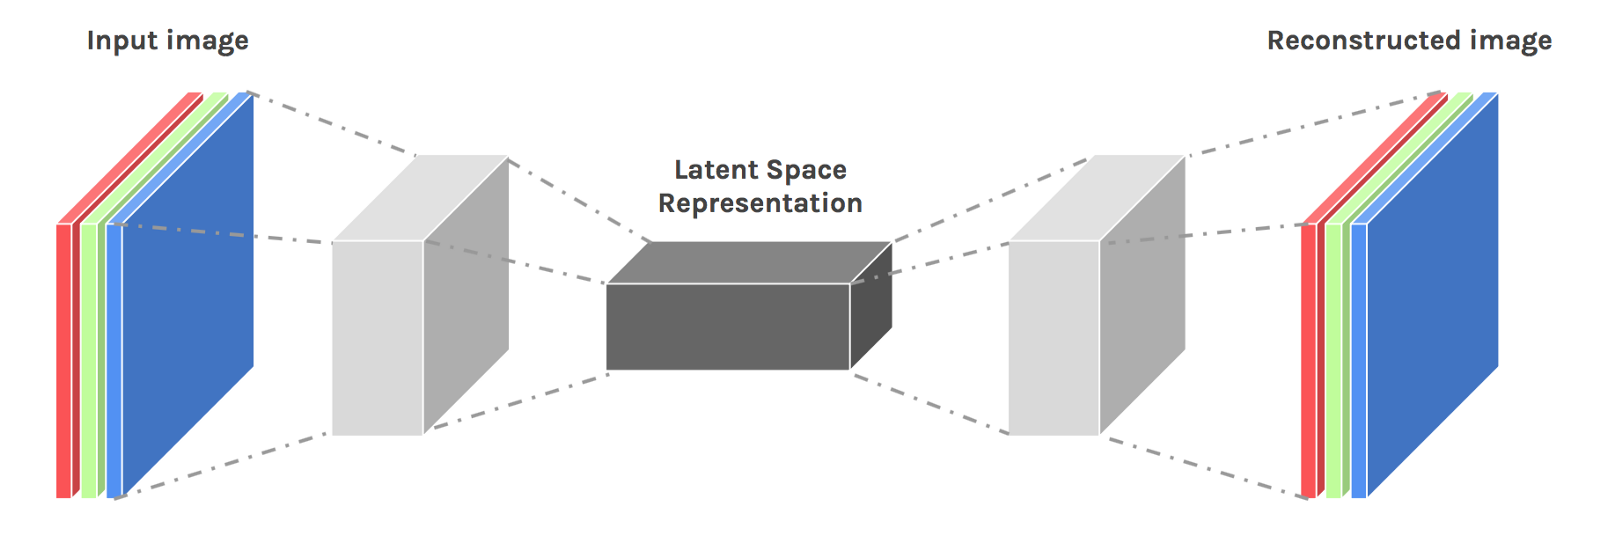

Here 
1. Input image is a black-white image.
2. The latent space is a representation of this image in a smaller dimension. 
3. The Reconstructed image is a color input image. </br>
All this happens as the model compares the reconstructed image with the color image(the one we have). By comparing is to find mean square error(i.e mse(color_image, models_output_color_image)) between images and then back prop to minimize this error.

In [14]:
import torch, os, cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,6)

## Download Dataset

In [2]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/3f83gxmv57-2.zip
!unzip -qq /content/3f83gxmv57-2.zip
!unzip -qq /content/"Citrus Plant Dataset"/Citrus.zip

--2021-03-18 05:39:24--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/3f83gxmv57-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.96.99
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.96.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66932143 (64M) [application/octet-stream]
Saving to: ‘3f83gxmv57-2.zip’

3f83gxmv57-2.zip    100%[===================>]  63.83M  16.9MB/s    in 3.8s    

2021-03-18 05:39:28 (16.9 MB/s) - ‘3f83gxmv57-2.zip’ saved [66932143/66932143]



In [3]:
images_paths = []
for f in os.listdir('/content/Citrus/Leaves'):
  images_paths.extend(['/content/Citrus/Leaves/'+f+'/'+x for x in os.listdir('/content/Citrus/Leaves/'+f)])

Show color images

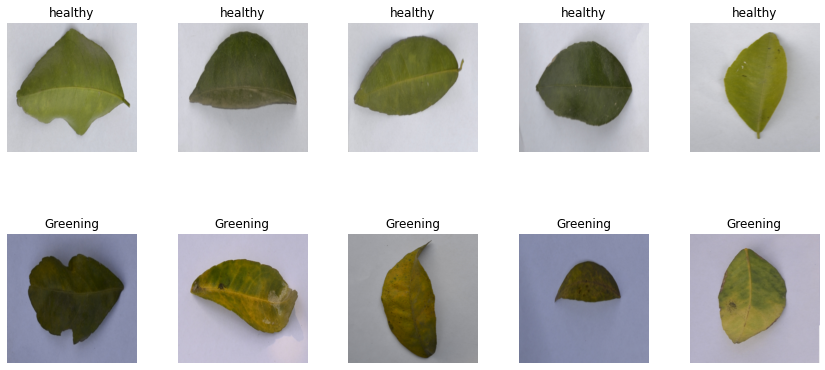

In [6]:
images_dirs = ['/content/Citrus/Leaves/healthy/', '/content/Citrus/Leaves/greening/']
sample_imgs = [images_dirs[0]+i for i in os.listdir(images_dirs[0])[:5]]
sample_imgs = sample_imgs + [images_dirs[1]+i for i in os.listdir(images_dirs[1])[:5]]
sample_labels = ["healthy"]*5 + ["Greening"]*5

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    im = Image.open(sample_imgs[a])
    axs[i,j].imshow(im)
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

Show b/w images

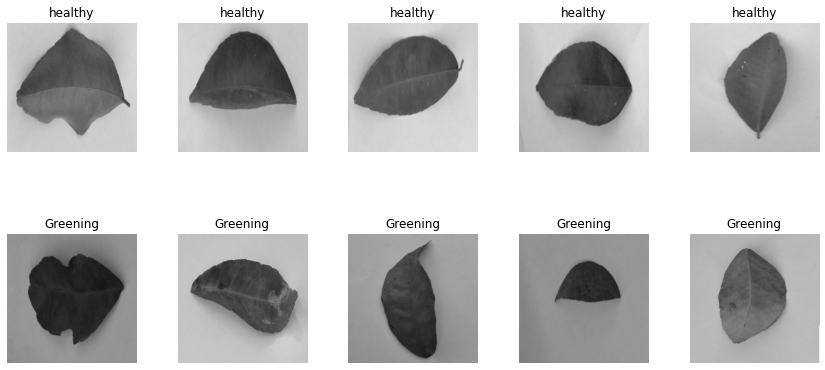

In [30]:
# sample some images

def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    im = cv2.imread(sample_imgs[a])
    im = rgb2gray(im)
    im = Image.fromarray(im)
    axs[i,j].imshow(im)
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

## Prepare Dataloader

In [62]:
class MakeDataset(Dataset):
    def __init__(self,images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image,(256,256)) 
        output_image = self.transform(image)   

        bw_image = np.dot(image[...,:3], [0.299, 0.587, 0.114])
        bw_image = bw_image/255.0
        input_image = self.transform(bw_image) 
        input_image = input_image.type(torch.float32)
        return input_image, output_image

In [63]:
BATCH_SIZE = 64

img_transform = transforms.Compose([                              
    transforms.ToTensor()
])

train_paths, test_paths = train_test_split(images_paths, test_size=0.1)

train_dataset = MakeDataset(train_paths, img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MakeDataset(test_paths, img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [64]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 256, 256]), torch.Size([3, 256, 256]))

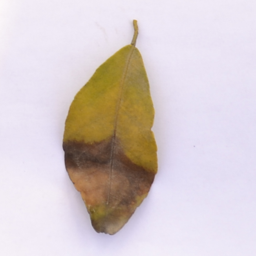

In [51]:
# sample image from loader
img = train_dataset[10][1].mul(255).permute(1, 2, 0).byte().numpy()
Image.fromarray(img)

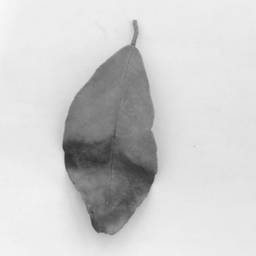

In [52]:
# sample b/w image from loader
img = train_dataset[10][0].mul(255).permute(1, 2, 0).byte().numpy().reshape(256,256)
Image.fromarray(img)

To build image coloring auto-encoder, input dimension should be 1 channel for b/w image and the output dimension 3 channels for color image.

In [67]:
# test, check, build auto encoder

print('input shape', train_dataset[0][0].shape)
x = nn.Conv2d(1, 128, 5, stride=2, padding=1)(train_dataset[0][0].reshape(1, 1, 256, 256))
x = nn.ReLU()(x)
x = nn.Conv2d(128, 128, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=2)(x)

x = nn.Conv2d(128, 128, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)
x = nn.Conv2d(128, 64, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)

x = nn.Conv2d(64, 64, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)

print('latent space shape', x.shape)

x = nn.ConvTranspose2d(64, 32, 2, stride=2)(x) # input latent space to decoder
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(32, 32, 2, stride=1)(x)
x = nn.ReLU()(x)

x = nn.ConvTranspose2d(32, 16, 2, stride=2)(x)
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(16, 16, 2, stride=1)(x)
x = nn.ReLU()(x)

x = nn.ConvTranspose2d(16, 3, 2, stride=1)(x)
print('decoder shape', x.shape) # (decoder output) make sure it is same size as input image

input shape torch.Size([1, 256, 256])
latent space shape torch.Size([1, 64, 63, 63])
decoder shape torch.Size([1, 3, 256, 256])


## Build Auto-Encoder

In [73]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 128, 5, stride=2, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2),
                                      nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(128, 64, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(64, 64, 3, stride=1, padding=1),
                                      nn.ReLU()
                                      )
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, 2, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(32, 32, 2, stride=1),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(32, 16, 2, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(16, 16, 2, stride=1),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(16, 3, 2, stride=1),
                                      nn.Sigmoid() # 0,1 outputs
                                      )

    def forward(self, x):
      x = self.encoder(x)
      x1 = self.decoder(x)
      return x1     

## Training

In [74]:
%%time

LR = 0.003
epochs = 50
print_epoch = 10
best_loss = 0.50
model_save_path = "/content/autoencoder1.bin"
model = AutoEncoder().cuda(0)
criterion = nn.MSELoss() # simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)

if os.path.isfile(model_save_path):
  save_m = torch.load(model_save_path)
  model.load_state_dict(save_m['model_state_dict'])
  optimizer.load_state_dict(save_m['optimizer_state'])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, last_epoch=save_m['prev_epoch'], eta_min=1e-7)
  scheduler.load_state_dict(save_m['scheduler_state'])
  print('loaded')

train_step = len(train_dataset)/BATCH_SIZE
print("--Training Started--")
for epoch in range(1,epochs+1):
  running_loss = 0.0
  for bw_images, images in train_dataloader:
    optimizer.zero_grad()
    images, bw_images = images.cuda(0), bw_images.cuda(0)
    output_images = model(bw_images)
    loss = criterion(images, output_images) 
    running_loss+=loss.detach()       
    loss.backward()
    optimizer.step() 
  train_loss = running_loss/train_step

  scheduler.step()
  if train_loss < best_loss:
    best_loss = train_loss
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'prev_epoch': epoch
            }, model_save_path)
  if epoch % print_epoch == 0:
    print("Epoch:", epoch)
    print("Train Loss:", train_loss.item())  

print('')    
print("--Training Complete--")    
print("Best loss:", best_loss.item())

--Training Started--
Epoch: 10
Train Loss: 0.006175795570015907
Epoch: 20
Train Loss: 0.0035897311754524708
Epoch: 30
Train Loss: 0.002959919162094593
Epoch: 40
Train Loss: 0.002654261887073517
Epoch: 50
Train Loss: 0.002530415542423725

--Training Complete--
Best loss: 0.0025189765729010105
CPU times: user 2min 48s, sys: 28.4 s, total: 3min 16s
Wall time: 3min 15s


## Results

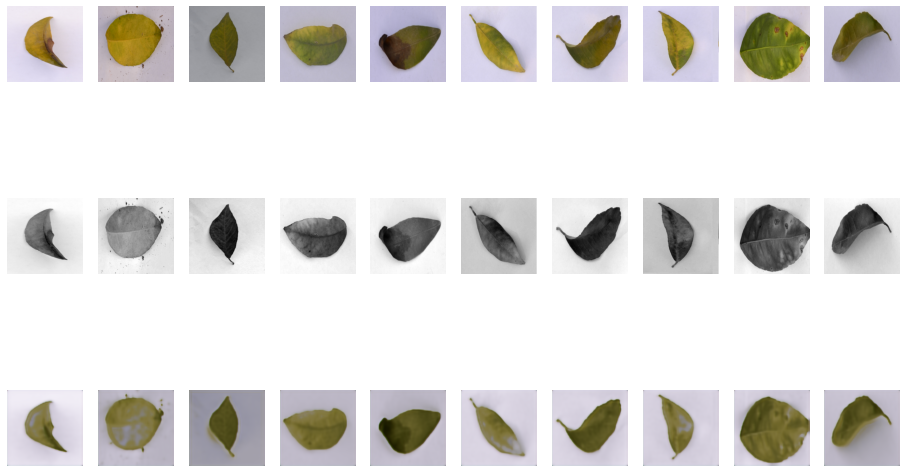

In [75]:
if os.path.isfile('/content/autoencoder1.bin'):
  model.load_state_dict(torch.load(model_save_path)["model_state_dict"])

for bw_images, color_images in test_dataloader:  
  color_images, bw_images = color_images.cuda(0), bw_images.cuda(0)
  output_images = model(bw_images)
  break

ROWS, COLS = 3, 10
f, axs = plt.subplots(ROWS,COLS, figsize=(16,10))
a,b,c= 0,0,0

for i in range(ROWS):
  for j in range(COLS):

    if i == 0:  
      im = color_images[a].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy() # original image
      axs[i,j].imshow(im)
      a+=1
    elif i == 1:
      im = bw_images[b].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy().reshape(256,256)  # b/w image
      axs[i,j].imshow(im, cmap='gray')
      b+=1
    else:
      im = output_images[c].mul(255).permute(1, 2, 0).detach().cpu().byte().numpy() # colored image
      axs[i,j].imshow(im)
      c+=1

    axs[i,j].axis('off')

Summary: As we can see results are fine already, due to simplicity of this dataset the task was easy, but in most cases a bigger network, extensive training is essential. Also with LAB color space image the results can be achived faster.